# Quantify isolation of Baffin Bay interior from Atlantic Water

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, TransformedBbox, BboxPatch, BboxConnector 
from matplotlib.transforms import Bbox
import cmocean
import pickle
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
import glob
from constants import imin, imax, jmin, jmax

%matplotlib inline

#### Parameters:

In [2]:
# Resolution of grid cells to show in figure:
grid_reso  = 10

# Colors:
land_color  = '#a9a7a2'
land_outline_color = '#373736'

years = range(2002,2022)
month_list = ['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.', 'Sep.','Oct.','Nov.', 'Dec.']

In [3]:
color_GS = '#065f59';
color_BB = '#5f8a64';
color_BI = '#caba96';

#### Load files:

In [5]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

# General file:
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]
e3t   = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]

#### Calculations

In [16]:
with xr.open_dataset(f'/data/brogalla/run_storage/Pb-reference-202312/climatology.nc') as comp1:
    dPb_ref = comp1['dissolpb'].values[:,0,:,:,:]

with xr.open_dataset(f'/data/brogalla/run_storage/Pb-Labrador-202312/climatology.nc') as comp2:
    dPb_LS  = comp2['dissolpb'].values[:,0,:,:,:]

In [17]:
# Create masks to isolate Baffin Bay interior and shelf regions

# --- Baffin Bay interior ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0 # isolate by depth=1000 m
    BB_mask[depth][mesh_lat <= 66]   = 0
    BB_mask[depth][mesh_lat > 75]    = 0

BB_mask[mesh_bathy < 0.1] = 0

# --- Baffin Island Shelf ---
BI_mask  = np.zeros(bathy_masked.shape)
BI_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BI_mask[depth][mesh_lon < -79]   = 0
    BI_mask[depth][mesh_lon > -40]   = 0
    BI_mask[depth][hdept >= 1000]    = 0 # isolate by depth=1000 m
    BI_mask[depth][mesh_lat <= 67]   = 0
    BI_mask[depth][mesh_lat > 73.5]  = 0
    BI_mask[depth][(mesh_lat < 71) & (mesh_lon < -71)]  = 0

    BI_mask[depth][(mesh_lat > 67)   & (mesh_lat < 77) & (mesh_lon > -59.5)]  = 0
    BI_mask[depth][(mesh_lat > 67.4) & (mesh_lat < 72) & (mesh_lon > -60)]  = 0
    BI_mask[depth][(mesh_lat > 68.4) & (mesh_lat < 77) & (mesh_lon > -62)]  = 0
    BI_mask[depth][(mesh_lat > 70)   & (mesh_lat < 77) & (mesh_lon > -65)]  = 0
    BI_mask[depth][(mesh_lat > 73)   & (mesh_lat < 77) & (mesh_lon > -71)]  = 0

BI_mask[mesh_bathy < 0.1] = 0

# --- West Greenland Shelf ---
WG_mask  = np.zeros(bathy_masked.shape)
WG_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    WG_mask[depth][mesh_lon < -69]   = 0
    WG_mask[depth][hdept >= 1000]    = 0 # isolate by depth=1000 m
    WG_mask[depth][mesh_lat <= 67]   = 0
    WG_mask[depth][mesh_lat > 77]    = 0
    WG_mask[depth][(mesh_lat > 64)  & (mesh_lat < 69) & (mesh_lon < -59.8)] = 0
    WG_mask[depth][(mesh_lat > 67)  & (mesh_lat < 73) & (mesh_lon < -64)]   = 0

WG_mask[mesh_bathy < 0.1] = 0

In [18]:
interior_Atl = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, (dPb_LS - dPb_ref).mean(axis=0)).mean(axis=(1,2))
Baffin_Atl   = np.ma.masked_where(BI_mask[:,imin:imax,jmin:jmax]==0, (dPb_LS - dPb_ref).mean(axis=0)).mean(axis=(1,2))
WestGr_Atl   = np.ma.masked_where(WG_mask[:,imin:imax,jmin:jmax]==0, (dPb_LS - dPb_ref).mean(axis=0)).mean(axis=(1,2))

In [19]:
monthly_BB_mask = np.tile(BB_mask[:,imin:imax,jmin:jmax], (12,1,1,1))
monthly_BI_mask = np.tile(BI_mask[:,imin:imax,jmin:jmax], (12,1,1,1))
monthly_WG_mask = np.tile(WG_mask[:,imin:imax,jmin:jmax], (12,1,1,1))

interior_Atl_monthly = np.ma.masked_where(monthly_BB_mask==0, (dPb_LS - dPb_ref)).mean(axis=(2,3))
Baffin_Atl_monthly   = np.ma.masked_where(monthly_BI_mask==0, (dPb_LS - dPb_ref)).mean(axis=(2,3))
WestGr_Atl_monthly   = np.ma.masked_where(monthly_WG_mask==0, (dPb_LS - dPb_ref)).mean(axis=(2,3))

In [20]:
dPb_interannual_Atl_BB = np.empty((len(years),50,12))
for y, year in enumerate(years):
    print(year)
    for mth in range(1,13):
        folder1 = f'/data/brogalla/run_storage/Pb-reference-202312/Pb-reference-{year}-202312/'
        folder2 = f'/data/brogalla/run_storage/Pb-Labrador-202312/Pb-Labrador-{year}-202312/'
        with xr.open_dataset(f'{folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{mth:02}-{year}{mth:02}.nc') as comp1:
            with xr.open_dataset(f'{folder2}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{mth:02}-{year}{mth:02}.nc') as comp2:        
                dPb_interannual_Atl_BB[y, :, mth-1] = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, \
                                                                   comp2['dissolpb'].values[0,:,:,:]- \
                                                                   comp1['dissolpb'].values[0,:,:,:]).mean(axis=(1,2))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


#### Figure:

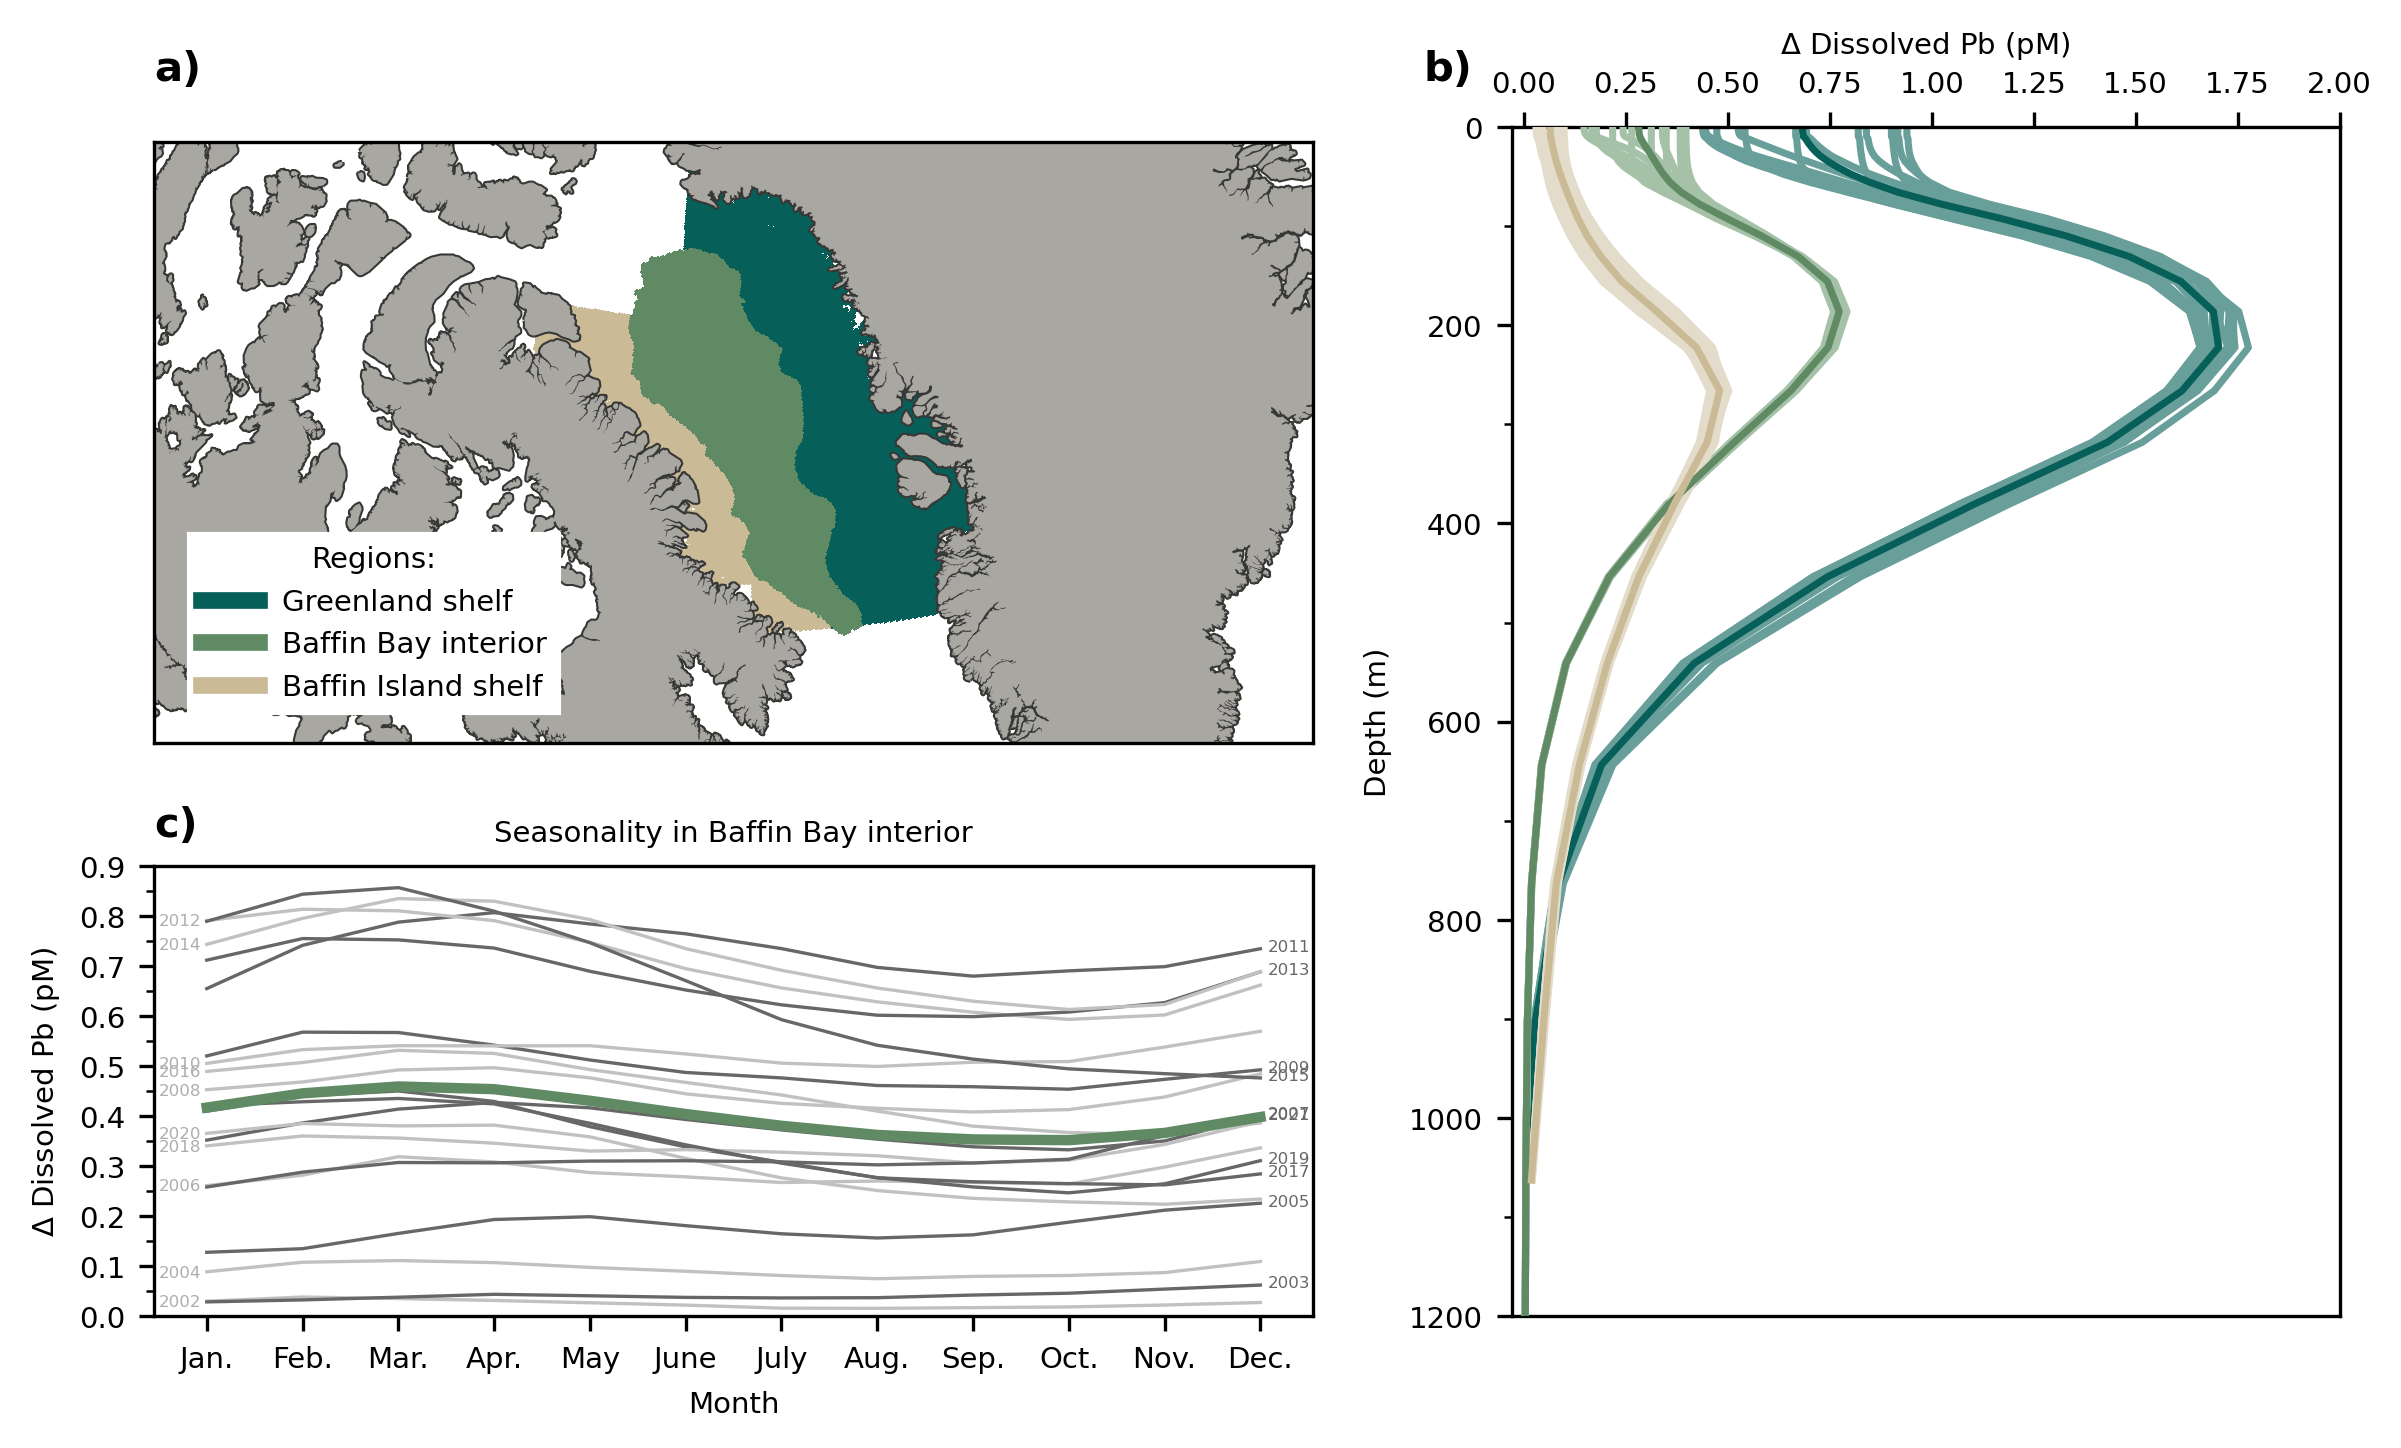

In [24]:
fig = plt.figure(figsize=(4.7*2,3.5*1.5), dpi=300)
gs  = fig.add_gridspec(2,2, width_ratios=[1.4, 1], height_ratios=[1.4,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

#------- map --------------------------
proj1=Basemap(projection='eqdc',lat_0 = 71, lon_0 = -65, resolution='i', width=2.7e6, height=1.4e6, ax=ax1)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);
layer=0
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
WG_mask_plot = np.ma.masked_where(WG_mask < 1, WG_mask)
BB_mask_plot = np.ma.masked_where(BB_mask < 1, BB_mask)
BI_mask_plot = np.ma.masked_where(BI_mask < 1, BI_mask)
proj1.pcolormesh(x, y, BI_mask_plot[layer,imin:imax,jmin:jmax], cmap=ListedColormap([color_BI]))
proj1.pcolormesh(x, y, WG_mask_plot[layer,imin:imax,jmin:jmax], cmap=ListedColormap([color_GS]))
proj1.pcolormesh(x, y, BB_mask_plot[layer,imin:imax,jmin:jmax], cmap=ListedColormap([color_BB]))
ax1.plot([0,0], [0,0], c=color_GS, lw=4, label='Greenland shelf')
ax1.plot([0,0], [0,0], c=color_BB, lw=4, label='Baffin Bay interior') 
ax1.plot([0,0], [0,0], c=color_BI, lw=4, label='Baffin Island shelf')

leg = ax1.legend(loc=(0.03, 0.05), fontsize=7, facecolor='white', fancybox=False, framealpha=1, edgecolor='white')
leg.set_title('Regions:', prop={'size':7})

#-------- seasonality ------------------
kwags1 = {'color':'#adadad', 'lw':0.8}
kwags3 = {'color':'#676767', 'lw':0.8}
kwags2 = {'lw':2.5}
dPb_total = np.zeros((12))
dt = 23 # depth level
for y, year in enumerate(years):
    dPb_weighted = np.array([dPb_interannual_Atl_BB[y,0:dt,m]*e3t[0:dt,0,0]*1e12 for m in range(0,12)])
    if (y % 2)==0:
        ax2.plot(month_list, np.sum(dPb_weighted, axis=1)/np.sum(e3t[0:dt,0,0]), '-', linewidth=0.8, color='#c1c1c1')
        ax2.text(-0.5, -0.01+np.sum(dPb_weighted, axis=1)[0]/np.sum(e3t[0:dt,0,0]), str(year), fontsize=4, color='#adadad')
    else:
        ax2.plot(month_list, np.sum(dPb_weighted, axis=1)/np.sum(e3t[0:dt,0,0]), '-', **kwags3)
        if year==2014 or year==2018:
            ax2.text(11.08, 0.008+np.sum(dPb_weighted, axis=1)[-1]/np.sum(e3t[0:dt,0,0]), str(year), fontsize=4, color='#676767')
        else:
            ax2.text(11.08, -0.005+np.sum(dPb_weighted, axis=1)[-1]/np.sum(e3t[0:dt,0,0]), str(year), fontsize=4, color='#676767')
    dPb_total += np.sum(dPb_weighted, axis=1)/np.sum(e3t[0:dt,0,0])
ax2.plot(month_list, dPb_total/len(years), **kwags2, color=color_BB)
ax2.tick_params(axis='both', labelsize=7)
ax2.set_xlabel('Month', fontsize=7)
ax2.set_ylabel(r'$\Delta$ Dissolved Pb (pM)', fontsize=7)
ax2.set_title('Seasonality in Baffin Bay interior', fontsize=7)
ax2.set_ylim(0.0, 0.9)
ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))

# ------- profile ----------------------
for month in range(0,12):
    ax3.plot(WestGr_Atl_monthly[month]*1e12, mesh_depth, c='#699f9b', lw=1.7)
    ax3.plot(Baffin_Atl_monthly[month]*1e12, mesh_depth, c='#e4dcca', lw=1.7, zorder=4)
    ax3.plot(interior_Atl_monthly[month]*1e12, mesh_depth, c='#a5c2a9', lw=1.7, zorder=3)
ax3.plot(WestGr_Atl*1e12, mesh_depth, '-', c=color_GS, lw=1.7)
ax3.plot(Baffin_Atl*1e12, mesh_depth, '-', c=color_BI, lw=1.7, zorder=5)
ax3.plot(interior_Atl*1e12, mesh_depth, '-', c=color_BB, lw=1.7, zorder=4)
    
ax3.yaxis.set_minor_locator(MultipleLocator(100))
ax3.xaxis.set_minor_locator(MultipleLocator(0.25))
ax3.set_ylim(1200,0)
ax3.set_xlim(-0.03,2.0)
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top') 
ax3.set_ylabel('Depth (m)', fontsize=7)
ax3.tick_params(axis='both', labelsize=7)
ax3.set_xlabel(r'$\Delta$ Dissolved Pb (pM)', fontsize=7)

fig.text(0.125, 0.91, 'a)', fontsize=10, weight='bold');
fig.text(0.575, 0.91, 'b)', fontsize=10, weight='bold');
fig.text(0.125, 0.43, 'c)', fontsize=10, weight='bold');

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_202402/R6-BB-isolation.jpg', dpi=300, bbox_inches='tight')

In [26]:
dPb_interannual_Atl_BB = np.empty((len(years),50,12))
# dPb_interannual_Atl_BI = np.empty((len(years),50,12))
# dPb_interannual_Atl_WG = np.empty((len(years),50,12))
for y, year in enumerate(years):
    print(year)
    for mth in range(1,13):
        folder1 = f'/data/brogalla/run_storage/Pb-reference-202312/Pb-reference-{year}-202312/'
        folder2 = f'/data/brogalla/run_storage/Pb-Labrador-202312/Pb-Labrador-{year}-202312/'
        with xr.open_dataset(f'{folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{mth:02}-{year}{mth:02}.nc') as comp1:
            with xr.open_dataset(f'{folder2}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{mth:02}-{year}{mth:02}.nc') as comp2:        
                dPb_interannual_Atl_BB[y, :, mth-1] = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]==0, \
                                                                   comp2['dissolpb'].values[0,:,:,:]- \
                                                                   comp1['dissolpb'].values[0,:,:,:]).mean(axis=(1,2))
#                 dPb_interannual_Atl_BI[y, :, mth-1] = np.ma.masked_where(BI_mask[:,imin:imax,jmin:jmax]==0, \
#                                                                    comp2['dissolpb'].values[0,:,:,:]- \
#                                                                    comp1['dissolpb'].values[0,:,:,:]).mean(axis=(1,2))
#                 dPb_interannual_Atl_WG[y, :, mth-1] = np.ma.masked_where(WG_mask[:,imin:imax,jmin:jmax]==0, \
#                                                                    comp2['dissolpb'].values[0,:,:,:]- \
#                                                                    comp1['dissolpb'].values[0,:,:,:]).mean(axis=(1,2))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


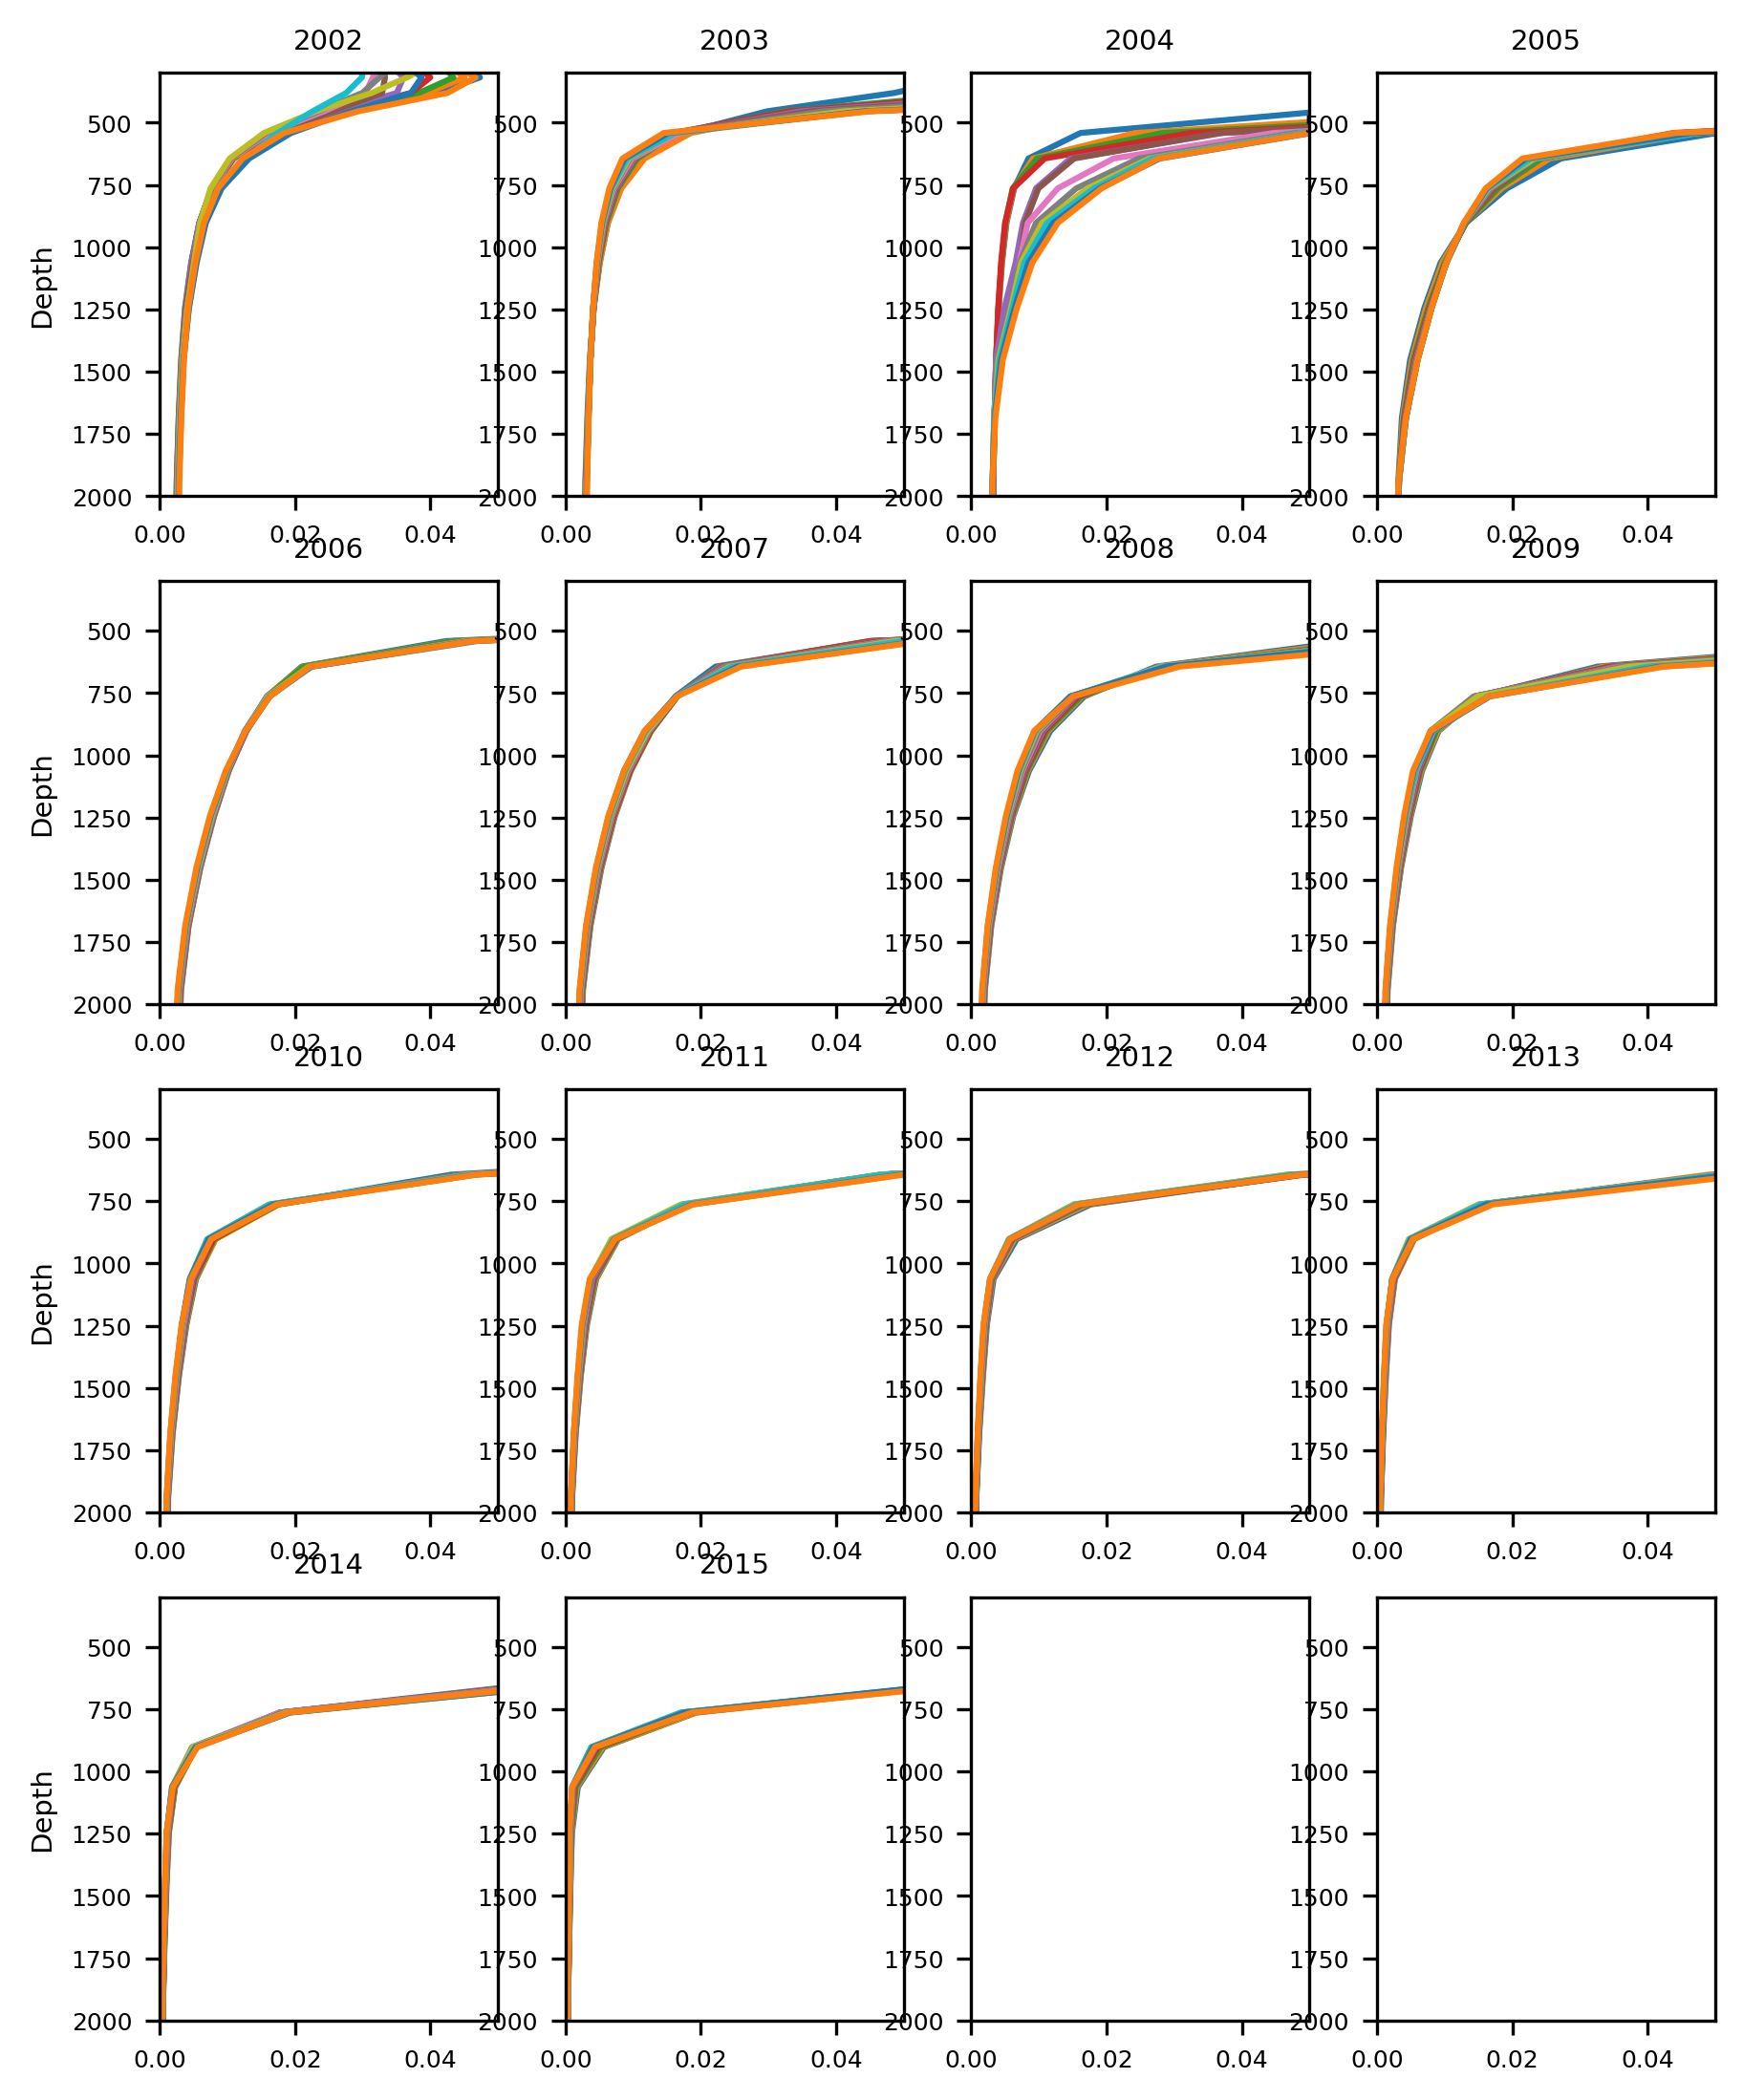

In [27]:
fig, ax = plt.subplots(4,4, figsize=(7,9), dpi=300)
for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlim(0,0.05)
    axis.set_ylim(2000,300)
    
for axis in ax[:,0].ravel():
    axis.set_ylabel('Depth', fontsize=7)

for n, axis in enumerate(ax.ravel()):
    if n < 14:
        axis.set_title(years[n], fontsize=7)
        for mth in range(0,12):
            axis.plot(dPb_interannual_Atl_BB[n,:,mth]*1e12, mesh_depth)
            
# ax[3,1].axis('off'); ax[3,2].axis('off'); ax[3,3].axis('off');